# Project Overview

**Latar Belakang :**

Dalam era digital saat ini, volume konten hiburan yang tersedia secara online tumbuh secara eksponensial. Platform seperti Netflix, Disney+, dan lainnya menyediakan ribuan pilihan film dan serial yang terus bertambah setiap hari. Namun, banyaknya pilihan justru menjadi tantangan tersendiri: pengguna sering merasa kewalahan dan kesulitan dalam menemukan tayangan yang sesuai dengan minat mereka. Hal ini berdampak pada turunnya pengalaman pengguna dan menurunnya loyalitas terhadap platform.

**Mengapa Project ini penting :**

1. **Pengalaman Pengguna yang Lebih Personal**
   Sistem rekomendasi yang baik membantu menyajikan konten yang sesuai dengan preferensi pengguna, tanpa harus mencarinya secara manual.

2. **Efisiensi Navigasi Konten**
   Dengan menyaring konten berdasarkan minat dan riwayat interaksi, pengguna dapat menghemat waktu dalam menemukan tayangan yang diinginkan.

# Business Undrestanding


**Problem Statement :**

1. **Bagaimana mengidentifikasi kesamaan antara film untuk menyarankan konten yang sesuai bagi pengguna?**

   * Menggunakan fitur-fitur seperti genre, popularitas, dan tahun rilis untuk menemukan keterkaitan antar film.

2. **Apa pendekatan terbaik untuk menyusun rekomendasi yang tidak monoton atau terlalu seragam?**

   * Dibutuhkan strategi untuk memperkenalkan keberagaman konten, agar pengguna tidak hanya mendapat saran dari genre atau tipe film yang sama.

3. **Bagaimana menyusun sistem yang tetap relevan meskipun pengguna tidak memberikan banyak umpan balik (seperti rating)?**

   * Fokus pada pendekatan berbasis konten (content-based) yang tidak sepenuhnya bergantung pada interaksi pengguna.

**Goals :**

1. **Membuat prototipe sistem rekomendasi yang mampu mengenali karakteristik film secara otomatis** dan menyarankan tayangan berdasarkan kedekatan atribut.
2. **Menerapkan teknik pengukuran kesamaan (similarity)** untuk menilai sejauh mana satu film mirip dengan film lainnya menggunakan data struktural.
3. **Mengintegrasikan elemen keberagaman dalam sistem rekomendasi**, agar pengguna tidak merasa jenuh dengan saran yang terlalu mirip secara berturut-turut.

# Import Library

In [1]:
# Import library
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import kagglehub
import os

# Data Understanding

Data yang digunakan adalah **MovieLens Latest Small Dataset** yang tersedia di Kaggle:
🔗 [https://www.kaggle.com/datasets/grouplens/movielens-latest-small](https://www.kaggle.com/datasets/grouplens/movielens-latest-small)

Dataset ini berisi informasi mengenai:

* **movies.csv** – data film termasuk movieId, title, dan genres
* **ratings.csv** – data rating pengguna terhadap film (userId, movieId, rating, timestamp)
* **tags.csv** – data tag yang diberikan pengguna terhadap film
* **links.csv** – penghubung antara movieId dan ID film dari sumber eksternal seperti IMDB dan TMDb



In [6]:
#!/bin/bash
!curl -L -o movielens-latest-small.zip\
  https://www.kaggle.com/api/v1/datasets/download/grouplens/movielens-latest-small

!unzip movielens-latest-small.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  970k  100  970k    0     0  1541k      0 --:--:-- --:--:-- --:--:-- 1541k
Archive:  movielens-latest-small.zip
  inflating: README.md               
  inflating: links.csv               
  inflating: movies.csv              
  inflating: ratings.csv             
  inflating: tags.csv                


In [8]:
movies = pd.read_csv('movies.csv')
links = pd.read_csv('links.csv')
tags = pd.read_csv('tags.csv')
ratings = pd.read_csv('ratings.csv')

print('Jumlah data film: ', len(movies.movieId.unique()))
print('Jumlah data link film: ', len(links.movieId.unique()))
print('Jumlah data tag pada film yang diberikan pengguna: ', len(tags.tag.unique()))
print('Jumlah data penilaian yang diberikan pengguna: ', len(ratings))

Jumlah data film:  9742
Jumlah data link film:  9742
Jumlah data tag pada film yang diberikan pengguna:  1589
Jumlah data penilaian yang diberikan pengguna:  100836


# Univariate Exploratory Data Analysis

**Variabel-variabel pada MovieLens Latest Dataset adalah sebagai berikut:**

* **movies** : merupakan metadata dari setiap film, yang mencakup informasi seperti judul dan genre.
* **links** : merupakan ID referensi eksternal film yang terhubung ke situs IMDb dan TMDb.
* **tags** : merupakan kata kunci atau deskripsi tambahan yang diberikan oleh pengguna terhadap film tertentu.
* **ratings** : berisi data penilaian (rating) yang diberikan pengguna terhadap film, termasuk userId, movieId, rating, dan timestamp.

Data yang tersedia memang terlihat cukup sederhana, namun cukup representatif untuk membangun sistem rekomendasi. Dalam tahap awal ini, kita akan mengambil sampel berdasarkan kombinasi movieId dan userId dari file **ratings.csv**.

## Movies

Menampilkan informasi umum tentang struktur DataFrame, termasuk jumlah entri, jumlah kolom, nama dan tipe data setiap kolom, serta jumlah non-null pada masing-masing kolom.

In [9]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


Berdasarkan output di atas, dataset movies memiliki **9742 entri (baris)** dan **3 kolom**, yaitu:

* movieId : ID unik untuk setiap film dengan tipe data int64
* title : Judul film dengan tipe data object (string)
* genres : Genre film dengan tipe data object (string), berisi satu atau lebih genre yang dipisahkan dengan simbol |


Menampilkan 5 baris pertama dari DataFrame untuk melihat contoh isi data pada setiap kolom.

In [10]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Mengekstrak dan menampilkan daftar genre unik yang terdapat dalam dataset movies

In [11]:
# filter berdasarkan genre
unique_genres = set()

for genre_list in movies['genres']:
    genres_split = genre_list.split('|')
    unique_genres.update(genres_split)

print(f"Terdapat {len(unique_genres)} jenis genre:")
print(sorted(unique_genres))

Terdapat 20 jenis genre:
['(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


Berdasarkan output di atas, terdapat 20 jenis genre unik dalam dataset movies. Genre (no genres listed) menunjukkan bahwa terdapat film yang belum memiliki informasi genre.

Melakukan filter terhadap data untuk menemukan film yang tidak memiliki genre

In [12]:
# Filter film yang tidak memiliki genre (no genres listed)
no_genre_movies = movies[movies['genres'] == '(no genres listed)']

print(f"Jumlah film yang tidak memiliki genre (no genres listed): {len(no_genre_movies)}")

Jumlah film yang tidak memiliki genre (no genres listed): 34


Berdasarkan hasil filter, terdapat 34 film dalam dataset yang tidak memiliki informasi genre ('(no genres listed)').

## Links

Menampilkan informasi struktur DataFrame links, termasuk jumlah entri, jumlah kolom, tipe data, dan jumlah non-null pada masing-masing kolom.

In [13]:
links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB



Berdasarkan output di atas, dataset links memiliki **9742 entri** dan **3 kolom**, yaitu:

* movieId : ID film yang sama dengan movieId pada dataset movies (tipe int64)
* imdbId : ID film pada basis data **IMDb** (tipe int64)
* tmdbId : ID film pada basis data **TMDb (The Movie Database)** (tipe float64)

Menampilkan 5 baris pertama dari DataFrame untuk melihat contoh isi data pada setiap kolom.

In [15]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


## Tags

Menampilkan informasi struktur DataFrame tags, termasuk jumlah entri, nama dan tipe kolom, jumlah nilai non-null di setiap kolom.

In [16]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


Berdasarkan output di atas, dataset tags memiliki **3683 entri** dan **4 kolom**, yaitu:

* userId : ID pengguna yang memberikan tag (tipe int64)
* movieId : ID film yang diberi tag (tipe int64)
* tag : Tag atau label yang diberikan pengguna untuk film tersebut (tipe object)
* timestamp : Waktu saat tag diberikan dalam bentuk timestamp UNIX (tipe int64)

Menampilkan 5 baris pertama dari DataFrame untuk melihat contoh isi data pada setiap kolom.

In [17]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


## Ratings

Menampilkan 5 baris pertama dari DataFrame untuk melihat contoh isi data pada setiap kolom.

In [18]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Melihat statistik deskriptif dari dataset rating.

In [19]:
ratings.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


Menampilkan jumlah data (count), nilai rata-rata (mean), standar deviasi (std), nilai minimum, kuartil (25%, 50%, 75%), dan nilai maksimum untuk setiap kolom numerik.

Menghitung jumlah unik pengguna, jumlah unik film, dan total jumlah data rating yang terdapat dalam dataset ratings.

In [20]:
print('Jumlah userID: ', len(ratings.userId.unique()))
print('Jumlah placeID: ', len(ratings.movieId.unique()))
print('Jumlah data rating: ', len(ratings))

Jumlah userID:  610
Jumlah placeID:  9724
Jumlah data rating:  100836


Berdasarkan output di atas:

* Jumlah pengguna unik (`userId`) yang memberikan rating adalah **610**
* Jumlah film unik (`movieId`) yang telah diberi rating adalah **9724**
* Total jumlah rating yang tercatat dalam dataset adalah **100,836**

# Data Preprocessing

## Menggabungkan Data dengan Fitur Nama film

mendefinisikan dataframe rating ke dalam variabel all_movie_rate

In [26]:
all_movie_rate = ratings
all_movie_rate

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


Menggabungkan DataFrame all_movie_rate dengan DataFrame movies berdasarkan kolom movieId menggunakan metode left join, sehingga setiap baris rating akan dilengkapi dengan informasi judul film (title).

In [31]:
# Menggabungkan all movie_rate dengan dataframe movies berdasarkan movieId
all_movie_name = pd.merge(all_movie_rate, movies[['movieId', 'title']], on='movieId', how='left')

# Print dataframe all_movie_name
all_movie_name

,userId,movieId,rating,timestamp,title
0,1,1,4.0,964982703,Toy Story (1995)
1,1,3,4.0,964981247,Grumpier Old Men (1995)
2,1,6,4.0,964982224,Heat (1995)
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995)
4,1,50,5.0,964982931,"Usual Suspects, The (1995)"
...,...,...,...,...,...
100831,610,166534,4.0,1493848402,Split (2017)
100832,610,168248,5.0,1493850091,John Wick: Chapter Two (2017)
100833,610,168250,5.0,1494273047,Get Out (2017)
100834,610,168252,5.0,1493846352,Logan (2017)


##  Menggabungkan Data Rating dengan Fitur Genre Film

Menggabungkan Data Rating dengan Fitur Genre Film

In [21]:
movies_ratings = pd.merge(ratings, movies, on='movieId', how='left')
movies_ratings

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
...,...,...,...,...,...,...
100831,610,166534,4.0,1493848402,Split (2017),Drama|Horror|Thriller
100832,610,168248,5.0,1493850091,John Wick: Chapter Two (2017),Action|Crime|Thriller
100833,610,168250,5.0,1494273047,Get Out (2017),Horror
100834,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi


Melakukan pengelompokan data berdasarkan movieId dan title, kemudian menghitung jumlah total rating untuk setiap film. Hasilnya diurutkan dari yang memiliki total rating tertinggi ke yang terendah.

In [22]:
movies_ratings[['movieId', 'title', 'rating']].groupby(['movieId', 'title']).sum().reset_index().sort_values(by='rating', ascending=False)

,movieId,title,rating
277,318,"Shawshank Redemption, The (1994)",1404.0
314,356,Forrest Gump (1994),1370.0
257,296,Pulp Fiction (1994),1288.5
1938,2571,"Matrix, The (1999)",1165.5
510,593,"Silence of the Lambs, The (1991)",1161.0
...,...,...,...
6646,57326,In the Name of the King: A Dungeon Siege Tale ...,0.5
6528,54768,Daddy Day Camp (2007),0.5
6537,54934,"Brothers Solomon, The (2007)",0.5
8966,138798,Joe Dirt 2: Beautiful Loser (2015),0.5


# Data Preparation

## Mengatasi Missing Value

Mengecek missing value pada dataframe movies_ratings

In [30]:
movies_ratings.isnull().sum()

,0
userId,0
movieId,0
rating,0
timestamp,0
title,0
genres,0


berdasarkan hasil pengecekan dapat diinfokan bahwa tidak terdapat missing value

Mengecek missing value pada dataframe all_movie_name

In [32]:
all_movie_name.isnull().sum()

,0
userId,0
movieId,0
rating,0
timestamp,0
title,0


berdasarkan hasil pengecekan dapat diinfokan bahwa tidak terdapat missing value

## Menggabungkan Data Rating dengan Fitur Genre Film

Membuat variabel preparation yang berisi dataframe movies_ratings tanpa nilai movieId yang duplikat

In [33]:
preparation = movies_ratings
preparation.sort_values('movieId')

,userId,movieId,rating,timestamp,title,genres
6315,43,1,5.0,848993983,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
82207,522,1,3.0,1253344674,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
15041,96,1,5.0,964772990,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
65452,420,1,4.0,1218207191,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
67583,438,1,4.5,1105650469,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
...,...,...,...,...,...,...
27256,184,193581,4.0,1537109082,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
27257,184,193583,3.5,1537109545,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
27258,184,193585,3.5,1537109805,Flint (2017),Drama
27259,184,193587,3.5,1537110021,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


Membuang data duplikat pada variabel preparation

In [34]:
preparation = preparation.drop_duplicates('movieId')
preparation

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
...,...,...,...,...,...,...
100820,610,160341,2.5,1479545749,Bloodmoon (1997),Action|Thriller
100821,610,160527,4.5,1479544998,Sympathy for the Underdog (1971),Action|Crime|Drama
100823,610,160836,3.0,1493844794,Hazard (2005),Action|Drama|Thriller
100827,610,163937,3.5,1493848789,Blair Witch (2016),Horror|Thriller


Mengonversi kolom movieId, title, dan genres dari DataFrame preparation menjadi list untuk memudahkan pemrosesan data lebih lanjut.


In [36]:
# Mengonversi data series ‘movieId’ menjadi dalam bentuk list
movie_id = preparation['movieId'].tolist()

# Mengonversi data series ‘title’ menjadi dalam bentuk list
movie_title = preparation['title'].tolist()

# Mengonversi data series ‘genres’ menjadi dalam bentuk list
movie_genres = preparation['genres'].tolist()

print(len(movie_id))
print(len(movie_title))
print(len(movie_genres))

9724
9724
9724


Membuat dictionary untuk data movie_id, movie_title, dan movie_genres

In [37]:
movie_new = pd.DataFrame({
    'id': movie_id,
    'movie_title': movie_title,
    'movie_genres': movie_genres
})
movie_new

,id,movie_title,movie_genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,3,Grumpier Old Men (1995),Comedy|Romance
2,6,Heat (1995),Action|Crime|Thriller
3,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
...,...,...,...
9719,160341,Bloodmoon (1997),Action|Thriller
9720,160527,Sympathy for the Underdog (1971),Action|Crime|Drama
9721,160836,Hazard (2005),Action|Drama|Thriller
9722,163937,Blair Witch (2016),Horror|Thriller


# Model Development Content Based Filtering

Menampilkan 5 baris data acak dari DataFrame movie_new untuk melihat sampel isi dataset secara acak.

In [38]:
data = movie_new
data.sample(5)

,id,movie_title,movie_genres
6071,88954,"Very Harold & Kumar 3D Christmas, A (2011)",Comedy
5491,1685,"I Love You, I Love You Not (1996)",Drama|Romance
1523,1831,Lost in Space (1998),Action|Adventure|Sci-Fi
3095,89864,50/50 (2011),Comedy|Drama
1491,1562,Batman & Robin (1997),Action|Adventure|Fantasy|Thriller


## TF-IDF Vectorizer

Menginisialisasi model TfidfVectorizer

In [39]:
# Inisialisasi TfidfVectorizer
vectorizer = TfidfVectorizer()

# Melakukan perhitungan idf pada data genres
vectorizer.fit(data['movie_genres'])

# Mapping array dari fitur index integer ke fitur nama
vectorizer.get_feature_names_out()

array(['action', 'adventure', 'animation', 'children', 'comedy', 'crime',
       'documentary', 'drama', 'fantasy', 'fi', 'film', 'genres',
       'horror', 'imax', 'listed', 'musical', 'mystery', 'no', 'noir',
       'romance', 'sci', 'thriller', 'war', 'western'], dtype=object)

Melakukan fit lalu ditransformasikan ke bentuk matrix

In [40]:
tfidf_matrix = vectorizer.fit_transform(data['movie_genres'])
tfidf_matrix.shape

(9724, 24)

Mengubah vektor tf-idf dalam bentuk matriks dengan fungsi todense()

In [41]:
tfidf_matrix.todense()

matrix([[0.        , 0.41681721, 0.51634045, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.54896727, 0.        , 0.        , ..., 0.54222422, 0.        ,
         0.        ],
        ...,
        [0.64123095, 0.        , 0.        , ..., 0.63335461, 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.62477687, 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

Membuat dataframe untuk melihat tf-idf matrix

In [42]:
# Membuat dataframe untuk melihat tf-idf matrix
# Kolom diisi dengan genre film
# Baris diisi dengan judul film

pd.DataFrame(
    tfidf_matrix.todense(),
    columns=vectorizer.get_feature_names_out(),
    index=data.movie_title
).sample(21, axis=1).sample(10, axis=0)

,mystery,fi,crime,children,sci,horror,listed,genres,musical,documentary,...,war,animation,drama,imax,adventure,comedy,no,thriller,fantasy,noir
movie_title,,,,,,,,,,,,,,,,,,,,,
Ryuzo and the Seven Henchmen (2015),0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.590025,0.0,0.000000,0.000000,0.0
City of Ember (2008),0.0,0.493717,0.0,0.551991,0.493717,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.455844,0.000000,0.0,0.000000,0.000000,0.0
Zombeavers (2014),0.0,0.000000,0.0,0.000000,0.000000,0.705909,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.417916,0.0,0.000000,0.000000,0.0
Meet the Feebles (1989),0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.717562,0.0,...,0.0,0.618421,0.000000,0.0,0.000000,0.320406,0.0,0.000000,0.000000,0.0
Shrek (2001),0.0,0.000000,0.0,0.471016,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.481848,0.000000,0.0,0.388973,0.249647,0.0,0.000000,0.450779,0.0
Poltergeist III (1988),0.0,0.000000,0.0,0.000000,0.000000,0.780803,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.624777,0.000000,0.0
Howl (2010),0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,1.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0
Tenacious D in The Pick of Destiny (2006),0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.770736,0.0,...,0.0,0.000000,0.000000,0.0,0.536216,0.344149,0.0,0.000000,0.000000,0.0
Chaplin (1992),0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,1.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0


## Cosine Similarity

Menghitung cosine similarity pada matrix tf-idf

In [43]:
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1.        , 0.15262722, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.15262722, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.69543501, 0.33876915,
        0.        ],
       ...,
       [0.        , 0.        , 0.69543501, ..., 1.        , 0.39570531,
        0.        ],
       [0.        , 0.        , 0.33876915, ..., 0.39570531, 1.        ,
        0.78080334],
       [0.        , 0.        , 0.        , ..., 0.        , 0.78080334,
        1.        ]])

Membuat dataframe dari variabel cosine_sim dengan baris dan kolom berupa judul film

In [44]:
cosine_sim_df = pd.DataFrame(cosine_sim, index=data['movie_title'], columns=data['movie_title'])
print('Shape:', cosine_sim_df.shape)

cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (9724, 9724)


movie_title,"Sugarland Express, The (1974)",She's All That (1999),Cecil B. DeMented (2000),Sweetie (1989),Solaris (2002)
movie_title,,,,,
Stone Reader (2002),0.000000,0.000000,0.000000,0.000000,0.000000
Tokyo-Ga (1985),0.000000,0.000000,0.000000,0.000000,0.000000
Good Time (2017),0.503700,0.000000,0.000000,0.503700,0.158586
Tadpole (2002),0.466539,0.884500,0.504636,0.466539,0.502993
Judge Dredd (1995),0.000000,0.000000,0.000000,0.000000,0.610868
Creep 2 (2017),0.000000,0.290653,0.509442,0.000000,0.000000
"Dream Team, The (1989)",0.000000,0.570532,1.000000,0.000000,0.000000
"Little Vampire, The (2000)",0.000000,0.000000,0.000000,0.000000,0.000000
Ernest Goes to Camp (1987),0.000000,0.570532,1.000000,0.000000,0.000000


## Mendapatkan Rekomendasi

Mendefinisikan fungsi untuk merekomendasikan k film yang paling mirip berdasarkan skor kemiripan antar judul film menggunakan data cosine_sim_df.

In [46]:
def movie_recommendations(judul_film, similarity_data=cosine_sim_df, items=data[['movie_title', 'movie_genres']], k=5):
    """
    Rekomendasi film berdasarkan kemiripan dataframe

    Parameter:
    ---
    judul_film : tipe data string (str)
                Judul film (index kemiripan dataframe)
    similarity_data : tipe data pd.DataFrame (object)
                      Kesamaan dataframe, simetrik, dengan judul film sebagai
                      indeks dan kolom
    items : tipe data pd.DataFrame (object)
            Mengandung kedua nama dan fitur lainnya yang digunakan untuk mendefinisikan kemiripan
    k : tipe data integer (int)
        Banyaknya jumlah rekomendasi yang diberikan
    ---


    Pada index ini, kita mengambil k dengan nilai similarity terbesar
    pada index matrix yang diberikan (i).
    """

    # Mengambil data dengan menggunakan argpartition untuk melakukan partisi secara tidak langsung sepanjang sumbu yang diberikan
    # Dataframe diubah menjadi numpy
    # Range(start, stop, step)
    index = similarity_data.loc[:,judul_film].to_numpy().argpartition(
        range(-1, -k, -1))

    # Mengambil data dengan similarity terbesar dari index yang ada
    closest = similarity_data.columns[index[-1:-(k+2):-1]]

    # Drop judul_film agar judul film yang dicari tidak muncul dalam daftar rekomendasi
    closest = closest.drop(judul_film, errors='ignore')

    return pd.DataFrame(closest).merge(items).head(k)

Mencari dan menampilkan baris data yang memiliki judul film "Good Time (2017)" dari DataFrame data.

In [47]:
data[data.movie_title.eq('Good Time (2017)')]

,id,movie_title,movie_genres
9336,174727,Good Time (2017),Crime|Drama


berdasarkan output tersebut film "Good Time (2017) berada pada id "174727" dengan genre "Crime|Drama"

Menampilkan 5 rekomendasi film yang paling mirip dengan "Good Time (2017)" berdasarkan kemiripan genre menggunakan pendekatan TF-IDF dan cosine similarity.

In [49]:
movie_recommendations('Good Time (2017)')

,movie_title,movie_genres
0,Bob le Flambeur (1955),Crime|Drama
1,25th Hour (2002),Crime|Drama
2,Casino (1995),Crime|Drama
3,American Buffalo (1996),Crime|Drama
4,"Funeral, The (1996)",Crime|Drama


Berdasarkan hasil rekomendasi menggunakan metode **TF-IDF dan cosine similarity** terhadap genre film, sistem berhasil menyarankan 5 film yang memiliki genre serupa dengan **"Good Time (2017)"**, yaitu **Crime** dan **Drama**.


# Model Development dengan Collaborative Filtering

Membaca dataset

In [50]:
df = movies_ratings.drop(['genres', 'title'], axis=1)
df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


## Data Preparation

Mengonversi userId unik ke dalam list, melakukan encoding dari userId ke indeks numerik, serta menyediakan mapping balik dari indeks ke userId.

In [51]:
# Mengubah userId menjadi list tanpa nilai yang sama
user_ids = df['userId'].unique().tolist()
print('list userId: ', user_ids)

# Melakukan encoding userId
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print('encoded userId : ', user_to_user_encoded)

# Melakukan proses encoding angka ke ke userId
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print('encoded angka ke userId: ', user_encoded_to_user)

list userId:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219

Terdapat 610 pengguna unik, dan setiap userId telah berhasil diubah ke indeks numerik (0–609) menggunakan dua mapping—untuk konversi dua arah antara userId asli dan indeks—yang siap digunakan dalam model berbasis matriks atau embedding.

Mengonversi movieId unik ke dalam list, lalu membuat dua dictionary untuk encoding movieId ke indeks numerik dan sebaliknya.

In [52]:
# Mengubah movieId menjadi list tanpa nilai yang sama
movie_ids = df['movieId'].unique().tolist()

# Melakukan proses encoding movieId
movie_to_movie_encoded = {x: i for i, x in enumerate(movie_ids)}

# Melakukan proses encoding angka ke movieId
movie_encoded_to_movie = {i: x for i, x in enumerate(movie_ids)}

Melakukan mapping userId dan movieId ke bentuk encoded numerik di dataframe utama (df).

In [53]:
# Mapping userId ke dataframe user
df['user'] = df['userId'].map(user_to_user_encoded)

# Mapping movieId ke dataframe movie
df['movie'] = df['movieId'].map(movie_to_movie_encoded)

Mendapatkan statistik dasar seperti jumlah user, jumlah film, serta nilai minimum dan maksimum dari rating.

In [54]:
# Mendapatkan jumlah user
num_users = len(user_to_user_encoded)
print(num_users)

# Mendapatkan jumlah film
num_movie = len(movie_to_movie_encoded)
print(num_movie)

# Mengubah rating menjadi nilai float
df['rating'] = df['rating'].values.astype(np.float32)

# Nilai minimum rating
min_rating = min(df['rating'])

# Nilai maksimal rating
max_rating = max(df['rating'])

print('Number of User: {}, Number of Movie: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_movie, min_rating, max_rating
))

610
9724
Number of User: 610, Number of Movie: 9724, Min Rating: 0.5, Max Rating: 5.0


## Membagi Data untuk Training dan Validasi

Mengacak urutan baris pada dataframe df secara acak namun reproducible dengan random_state.

In [55]:
df = df.sample(frac=1, random_state=42)
df

,userId,movieId,rating,timestamp,user,movie
67037,432,77866,4.5,1335139641,431,4730
42175,288,474,3.0,978465565,287,474
93850,599,4351,3.0,1498524542,598,2631
6187,42,2987,4.0,996262677,41,194
12229,75,1610,4.0,1158989841,74,727
...,...,...,...,...,...,...
6265,42,4005,4.0,996259059,41,1873
54886,364,141,4.0,869443367,363,524
76820,480,6867,4.0,1179163171,479,2240
860,6,981,3.0,845556567,5,712


Mempersiapkan data input (x) dan target (y) untuk model, lalu membaginya menjadi data Training dan validasi.

In [56]:
# Membuat variabel x untuk mencocokkan data user dan movie menjadi satu value
x = df[['user', 'movie']].values

# Membuat variabel y untuk membuat rating dari hasil
y = df['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x, y)

[[ 431 4730]
 [ 287  474]
 [ 598 2631]
 ...
 [ 479 2240]
 [   5  712]
 [ 102 2046]] [0.88888889 0.55555556 0.55555556 ... 0.77777778 0.55555556 1.        ]


## Proses Training

melakukan pemodelan RecommenderNet menggunakan pendekatan matrix factorization berbasis embedding untuk memprediksi skor kecocokan antara pengguna dan film menggunakan arsitektur Keras.

In [57]:
class RecommenderNet(tf.keras.Model):

  # Insialisasi fungsi
  def __init__(self, num_users, num_movie, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_movie = num_movie
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1) # layer embedding user bias
    self.movie_embedding = layers.Embedding( # layer embeddings movie
        num_movie,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.movie_bias = layers.Embedding(num_movie, 1) # layer embedding movie bias

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    movie_vector = self.movie_embedding(inputs[:, 1]) # memanggil layer embedding 3
    movie_bias = self.movie_bias(inputs[:, 1]) # memanggil layer embedding 4

    dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)

    x = dot_user_movie + user_bias + movie_bias

    return tf.nn.sigmoid(x) # activation sigmoid

 inisialisasi model

In [58]:
model = RecommenderNet(num_users, num_movie, 50)

# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

Memulai training model

In [59]:
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 32,
    epochs = 50,
    validation_data = (x_val, y_val)
)

Epoch 1/50
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - loss: 0.6543 - root_mean_squared_error: 0.2491 - val_loss: 0.6172 - val_root_mean_squared_error: 0.2113
Epoch 2/50
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - loss: 0.6129 - root_mean_squared_error: 0.2071 - val_loss: 0.6133 - val_root_mean_squared_error: 0.2069
Epoch 3/50
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 36s 7ms/step - loss: 0.6071 - root_mean_squared_error: 0.2012 - val_loss: 0.6107 - val_root_mean_squared_error: 0.2040
Epoch 4/50
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 0.6048 - root_mean_squared_error: 0.1980 - val_loss: 0.6102 - val_root_mean_squared_error: 0.2033
Epoch 5/50
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - loss: 0.6024 - root_mean_squared_error: 0.1955 - val_loss: 0.6089 - val_root_mean_squared_error: 0.2017
Epoch 6/50
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - loss: 0.6029 - root_mean_squared_error: 0.1961 - val_loss: 0.6097 - val_root_mean_squared_error: 0.2026
Epoch 7/50
2521/2521 ━━━━━━━━━━━━━

## Visualisasi Metrik

visualisasi grafik RMSE Train dan Validation

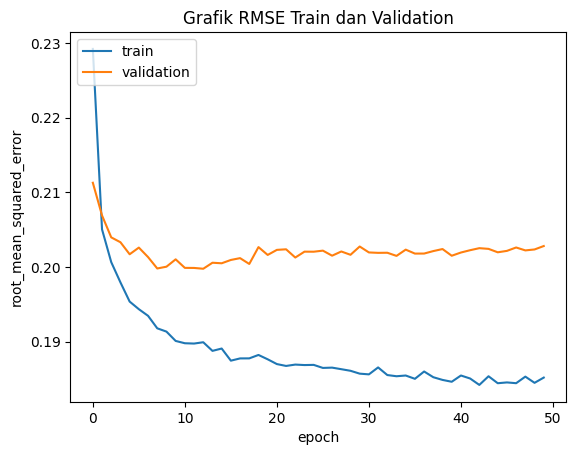

In [63]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('Grafik RMSE Train dan Validation')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Grafik menunjukkan bahwa nilai RMSE pada data training terus menurun seiring bertambahnya epoch, sementara nilai RMSE pada data validation cenderung stabil setelah beberapa epoch. Ini menandakan model berhasil mempelajari pola dari data.


## Mendapatkan Rekomendasi Film

Membuat array kombinasi user dan film yang belum ditonton untuk keperluan prediksi rekomendasi.

In [64]:
movie_df = movie_new
df = movies_ratings.drop(['genres', 'title'], axis=1)

# Mengambil sample user
user_id = df.userId.sample(1).iloc[0]
movie_watched_by_user = df[df.userId == user_id]

# Operator bitwise (~), bisa diketahui di sini https://docs.python.org/3/reference/expressions.html
movie_not_watched = movie_df[~movie_df['id'].isin(movie_watched_by_user.movieId.values)]['id']
movie_not_watched = list(
    set(movie_not_watched)
    .intersection(set(movie_to_movie_encoded.keys()))
)

movie_not_watched = [[movie_to_movie_encoded.get(x)] for x in movie_not_watched]
user_encoder = user_to_user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movie_not_watched), movie_not_watched)
)

Menampilkan film terbaik yang pernah ditonton user dan memberikan 10 rekomendasi film berdasarkan prediksi model.

In [67]:
ratings = model.predict(user_movie_array).flatten()

top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded_to_movie.get(movie_not_watched[x][0]) for x in top_ratings_indices
]

print('Showing recommendations for users: {}'.format(user_id))
print('===' * 9)
print('Movies with high ratings from user')
print('----' * 8)

top_movie_user = (
    movie_watched_by_user.sort_values(
        by = 'rating',
        ascending=False
    )
    .head(5)
    .movieId.values
)

movie_df_rows = movie_df[movie_df['id'].isin(top_movie_user)]
for row in movie_df_rows.itertuples():
    print(row.movie_title, ':', row.movie_genres)

print('----' * 8)
print('Top 10 Movies Recommendation')
print('----' * 8)

recommended_movies = movie_df[movie_df['id'].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.movie_title, ':', row.movie_genres)

300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Showing recommendations for users: 376
Movies with high ratings from user
--------------------------------
Twelve Monkeys (a.k.a. 12 Monkeys) (1995) : Mystery|Sci-Fi|Thriller
Apollo 13 (1995) : Adventure|Drama|IMAX
Terminator 2: Judgment Day (1991) : Action|Sci-Fi
Crimson Tide (1995) : Drama|Thriller|War
Blade Runner (1982) : Action|Sci-Fi|Thriller
--------------------------------
Top 10 Movies Recommendation
--------------------------------
Band of Brothers (2001) : Action|Drama|War
Trial, The (Procès, Le) (1962) : Drama
Paths of Glory (1957) : Drama|War
Jonah Who Will Be 25 in the Year 2000 (Jonas qui aura 25 ans en l'an 2000) (1976) : Comedy
Adam's Rib (1949) : Comedy|Romance
Heidi Fleiss: Hollywood Madam (1995) : Documentary
Stunt Man, The (1980) : Action|Adventure|Comedy|Drama|Romance|Thriller
Enter the Void (2009) : Drama
Bad Boy Bubby (1993) : Drama
Belle époque (1992) : Comedy|Romance


Berikut kesimpulan akhir berdasarkan output rekomendasi untuk user dengan userId 376:

Dari hasil implementasi sistem rekomendasi menggunakan pendekatan **Collaborative Filtering**, kita berhasil memberikan rekomendasi yang relevan dan sesuai dengan preferensi pengguna. Dalam contoh ini, sistem menghasilkan rekomendasi untuk pengguna dengan userId 376, yang sebelumnya memberikan rating tinggi pada film bergenre *Sci-Fi*, *Drama*, *Thriller*, dan *War*, seperti **Twelve Monkeys**, **Apollo 13**, dan **Terminator 2**.

Rekomendasi yang diberikan pun menunjukkan konsistensi dengan pola preferensi pengguna. Film seperti **Band of Brothers**, **Paths of Glory**, dan **The Stunt Man** memiliki elemen genre yang selaras, terutama *Drama*, *War*, dan *Thriller*. Selain itu, sistem juga menyarankan beberapa film dari genre lain seperti *Comedy* dan *Romance*, menunjukkan bahwa model mampu mengenali kemungkinan preferensi tambahan berdasarkan kemiripan perilaku pengguna lain yang serupa.

Secara keseluruhan, hasil ini menunjukkan bahwa sistem **Collaborative Filtering** telah mampu mengidentifikasi pola dan memberikan rekomendasi film yang dipersonalisasi dengan baik, tanpa memerlukan data konten dari masing-masing film secara langsung. Keunggulan pendekatan ini terletak pada kemampuannya untuk menemukan kesamaan antar pengguna dan menggunakannya sebagai dasar rekomendasi, menjadikannya solusi yang efektif untuk sistem dengan interaksi pengguna yang cukup besar.
